In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from copy import deepcopy
from matplotlib import pyplot as plt

import os
import datetime
import time
import json
import pickle
import os

In [2]:
with open("config_general.json", "r") as f:
    config_general = json.load(f)
folder_path = config_general["data_root_path"]
epis_long_to_short = config_general["epis_long_to_short"]
epis = config_general["epis"]
wks = config_general["wks"]

## Read the data

In [3]:
df_phaseI = pd.read_csv(folder_path + "aggregated_all_phaseI.csv")

C:\ProgramPool\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (45,55,58,61,64,67,69,70,71,72,73,74,75,76,82,83,91,173,178,183,188,193,198,203,430,570,572,573,1490,1491,1492,1493,1494,1543,2191,2192,2196,2197,2201,2202,2206,2207,2211,2212,2216,2217,2221,2222,2226,2227,2231,2232,2236,2237,2241,2242,2246,2247,2251,2252,2256,2257,2261,2262,2266,2267,2271,2272,2276,2277,2281,2282,2286,2287,2291,2292,2296,2297,2301,2302,2306,2307,2311,2312,2316,2317,2321,2322,2326,2327,2331,2332) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df_phaseII = pd.read_csv(folder_path + "aggregated_all_phaseII.csv")

C:\ProgramPool\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (59,61,63,65,99,100,101,102,103,104,105,106,107,108,111,112,192,195,197,200,202,205,207,210,212,215,217,220,222,225,580,592,594,595,1565,1797,1798,1799,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,1810,1811,1812,1813,1814,1815,1816,1817,1818,1819,1820,1821,1822,1823,1824,1825,1826,1827,1828,1829,1830,1831,1832,1833,1834,1835,1836,1837,1838,1839,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857,1858,1859,1860,1861,1862,1863,1864,1865,1866,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050,2051,2052,2053,2054,2055,2056,2057,2058,2059,2060,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070,2071,2072,2073,2074,2075,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085,2086,2087,2088,

In [5]:
df_phaseI_uw = pd.read_csv(folder_path + "aggregated_all_phaseI_uw.csv")

C:\ProgramPool\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (358,359,360,361,362,398,399,400,401,402,553) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Common features between CMU Phase I and II

In [6]:
with open(folder_path + "feature_col_epis_cmu.json", "r") as f:
    feature_col_epis = json.load(f)
feature_cols = [y for x in feature_col_epis.keys() for y in feature_col_epis[x]]
feature_cols_sensor = {}
for row in feature_cols:
    s = row.split("_")
    if (s[1] not in feature_cols_sensor):
        feature_cols_sensor[s[1]] = [row]
    else:
        feature_cols_sensor[s[1]].append(row)

In [7]:
overlap_cols_ = list(set(df_phaseI.columns.tolist()).intersection(set(df_phaseII.columns.tolist())))
overlap_cols = [x for x in df_phaseI.columns.tolist() if x in overlap_cols_]
overlap_feature_cols = overlap_cols[:3] + overlap_cols[99:]

In [8]:
df_phaseI = deepcopy(df_phaseI[overlap_cols])
df_phaseII = deepcopy(df_phaseII[overlap_cols])

## Map the CMU and UW features

In [9]:
map_cmu_uw = {
    "call": "calls",
    "loc": "locations",
    "locMap":"locations",
    "blue":"bluetooth",
    "screen":"screen",   
}

In [10]:
feature_mappings_cmu_uw = {}
for f_origin in feature_cols:
    s = f_origin.split("_")
    sensor = s[1]
    f_name = "_".join(s[2:])
    if (sensor in map_cmu_uw):
        f_uw = map_cmu_uw[sensor] + "_" + f_name
        if (f_uw in df_phaseI_uw.columns.tolist()):
            feature_mappings_cmu_uw[f_origin] = f_uw
feature_mappings_cmu_uw["f_steps_sum_steps_allday"] = "steps"
feature_mappings_cmu_uw["f_slp_sum_length_bout_asleep_allday"] = "totalMinutesAsleep"
uw_cmu_rename = {v:k for k,v in feature_mappings_cmu_uw.items()}
df_phaseI_uw.rename(uw_cmu_rename, axis = 1, inplace = True)

In [11]:
len(uw_cmu_rename)

294

In [12]:
df_phaseI_uw = deepcopy(df_phaseI_uw[["PID", "date", "day"] + list(feature_mappings_cmu_uw.keys()) + \
                                      df_phaseI_uw.columns.tolist()[459:594] + df_phaseI_uw.columns.tolist()[595:846]])

In [13]:
df_phaseI_uw.shape

(33366, 683)

## Add phase and days-of-week columns

In [14]:
df_phaseI["phase"] = "I"
df_phaseII["phase"] = "II"
df_phaseI["wk"] = df_phaseI["date"].apply(lambda x : "wkdy" if pd.to_datetime(x).weekday() + 1 < 6 else "wkend")
df_phaseII["wk"] = df_phaseII["date"].apply(lambda x : "wkdy" if pd.to_datetime(x).weekday() + 1 < 6 else "wkend")

In [15]:
cols = list(df_phaseI.columns)
re_order_cols = cols[:3] + cols[-2:] + cols[3:-2]

In [16]:
df_phaseI = deepcopy(df_phaseI[re_order_cols])
df_phaseII = deepcopy(df_phaseII[re_order_cols])

In [17]:
df_phaseI_grp = df_phaseI.groupby("PID")
df_phaseII_grp = df_phaseII.groupby("PID")

In [18]:
df_phaseI_uw["phase"] = "I"
df_phaseI_uw["wk"] = df_phaseI_uw["date"].apply(lambda x : "wkdy" if pd.to_datetime(x).weekday() + 1 < 6 else "wkend")
cols = list(df_phaseI_uw.columns)
re_order_cols = cols[:3] + cols[-2:] + cols[3:-2]
df_phaseI_uw = deepcopy(df_phaseI_uw[re_order_cols])

In [19]:
df_phaseI_uw_grp = df_phaseI_uw.groupby("PID")

## Extract PID with valid BDI results

In [20]:
pid_list_phaseI = []
pid_list_phaseII = []
pid_list_phaseI_uw = []

missing_rate_phaseI = {}
missing_rate_phaseII = {}
missing_rate_phaseI_uw = {}

score_phaseI = []
score_phaseII = []
score_phaseI_uw = []

for grp, df in df_phaseI_grp:    
    if (sum(df["BDI_II_POST"].isna()) == 0):
        if (max(df["BDI_II_POST"]) < 100):
            if ((df["BDI_II_POST"]).mean() != max(df["BDI_II_POST"])):
                print("shit")
            pid_list_phaseI.append(grp)
            missing_rate_phaseI[grp] = {}
            for sensor, cols in feature_cols_sensor.items():
                missing_rate_phaseI[grp][sensor] = (df[cols].isna().sum(axis = 0) / df[cols].shape[0]).mean()
            score_phaseI.append(df["BDI_II_POST"].mean())
for grp, df in df_phaseII_grp:
    if (sum(df["BDI_II_POST"].isna()) == 0):
        if (max(df["BDI_II_POST"]) < 100):
            if ((df["BDI_II_POST"]).mean() != max(df["BDI_II_POST"])):
                print("shit")
            pid_list_phaseII.append(grp)
            missing_rate_phaseII[grp] = {}
            for sensor, cols in feature_cols_sensor.items():
                missing_rate_phaseII[grp][sensor] = (df[cols].isna().sum(axis = 0) / df[cols].shape[0]).mean()
            score_phaseII.append(df["BDI_II_POST"].mean())
        else:
            print("100")
    else:
        print("isna")
for grp, df in df_phaseI_uw_grp:    
    if (sum(df["BDI_II_POST"].isna()) == 0):
        if (max(df["BDI_II_POST"]) < 100 and max(df["BDI_II_POST"]) > 0):
            if ((df["BDI_II_POST"]).mean() != max(df["BDI_II_POST"])):
                print("shit")
            pid_list_phaseI_uw.append(grp)
#             missing_rate_phaseI_uw[grp] = {}
#             for sensor, cols in feature_cols_sensor.items():
#                 missing_rate_phaseI_uw[grp][sensor] = (df[cols].isna().sum(axis = 0) / df[cols].shape[0]).mean()
            score_phaseI_uw.append(df["BDI_II_POST"].mean())

isna
isna
isna
isna
isna
isna
isna
isna
isna
isna
isna
isna
isna
isna
isna
isna
isna
isna
isna
isna
isna
isna
isna
isna
isna


### Visualize missing data

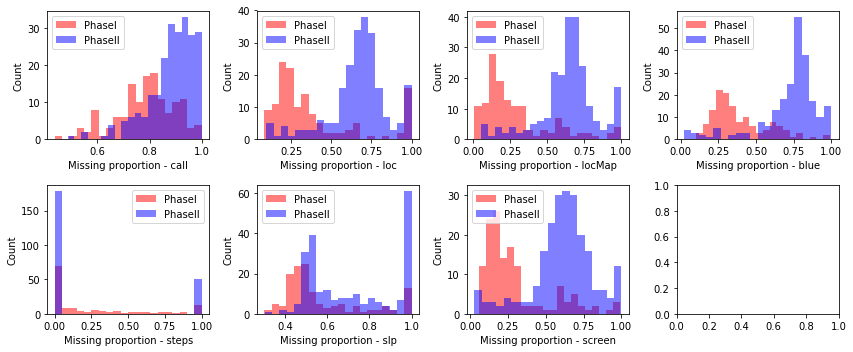

In [21]:
count = 0
fig, axes = plt.subplots(ncols = 4, nrows = 2, figsize = (12,5))
for sensor in feature_cols_sensor:
    ax = axes[count // 4][count % 4]
    ax.hist(list([missing_rate_phaseI[x][sensor] for x in missing_rate_phaseI]), alpha = 0.5, bins = 20, color = "red", label = "PhaseI")
    ax.hist(list([missing_rate_phaseII[x][sensor] for x in missing_rate_phaseII]), alpha = 0.5, bins = 20, color = "blue", label = "PhaseII")
    ax.legend()
    ax.set_ylabel("Count")
    ax.set_xlabel("Missing proportion - " + sensor)
    count += 1
plt.tight_layout()
plt.show()
# plt.savefig("missing_info.pdf")

### Count feature number (only for CMU now)

In [ ]:
df_phaseI_grp = df_phaseII.groupby("PID")
cols = [
"f_screen_number_samples_screen_allday",
"f_call_number_rows_calls_allday",
"f_blue_number_samples_bluetooth_allday",
"f_loc_number_samples_location_allday",
"f_slp_num_samples_sleep_allday",
"f_steps_num_samples_steps_allday"]
pid_counts = []
for i, df_buf in df_phaseI_grp:
    if (sum(df_buf["BDI_II_POST"] >= 0) > 0):
        pid_counts.append(df_buf[cols].sum().tolist())
pid_counts = pd.DataFrame(pid_counts)
for i,j in zip(pid_counts.mean(axis = 0), pid_counts.std(axis = 0)):
    print(round(i,1), round(j,1))

## Get BDI-valid data

In [22]:
df_phaseI_bdivalid = deepcopy(df_phaseI[df_phaseI["PID"].apply(lambda x : x in pid_list_phaseI)])
df_phaseII_bdivalid = deepcopy(df_phaseII[df_phaseII["PID"].apply(lambda x : x in pid_list_phaseII)])

In [23]:
df_phaseI_uw_bdivalid = deepcopy(df_phaseI_uw[df_phaseI_uw["PID"].apply(lambda x : x in pid_list_phaseI_uw)])

In [24]:
df_phaseI_bdivalid["PID"] = df_phaseI_bdivalid["PID"].astype(int)
df_phaseII_bdivalid["PID"] = df_phaseII_bdivalid["PID"].astype(int)
df_phaseI_uw_bdivalid["PID"] = df_phaseI_uw_bdivalid["PID"].astype(int)

## Get overlap between CMU Phase I and II

In [25]:
phase_I2II_mapping = pd.read_csv(folder_path + "PID-mapping.csv")

In [26]:
phase_I2II_mapping = phase_I2II_mapping.reset_index()
phase_I2II_mapping.rename({"index":"PID_new"}, axis = 1, inplace = True)
phase_I2II_mapping["PID_new"] += 1

In [27]:
overlap_phaseI = list(set(phase_I2II_mapping["PhaseI"].tolist()))
overlap_phaseII = list(set(phase_I2II_mapping["PhaseII"].tolist()))

In [28]:
df_phaseI_select = deepcopy(df_phaseI_bdivalid[df_phaseI_bdivalid["PID"].apply(lambda x : x in overlap_phaseI)])

In [29]:
df_phaseI_select.shape

(7844, 2211)

In [30]:
df_phaseII_select = deepcopy(df_phaseII_bdivalid[df_phaseII_bdivalid["PID"].apply(lambda x : x in overlap_phaseII)])

In [31]:
df_phaseII_select.shape

(8424, 2211)

In [32]:
df_phaseI_select["PID"] = df_phaseI_select["PID"].map({r["PhaseI"]:r["PID_new"] for i, r in phase_I2II_mapping.iterrows()})
df_phaseII_select["PID"] = df_phaseII_select["PID"].map({r["PhaseII"]:r["PID_new"] for i, r in phase_I2II_mapping.iterrows()})
df_phaseI_select["PID"] = df_phaseI_select["PID"].astype(int)
df_phaseII_select["PID"] = df_phaseII_select["PID"].astype(int)

### Remove the overlap students from CMU phase II

In [33]:
df_phaseII_bdivalid = deepcopy(df_phaseII_bdivalid[df_phaseII_bdivalid["PID"].apply(lambda x : x not in overlap_phaseII)])

In [34]:
df_phaseII_bdivalid.shape

(16200, 2211)

## Get BDI data

In [35]:
def from_two_cols_to_dict(x):
    return {r[0]:r[1] for i, r in x.iterrows()}

In [36]:
phaseI_BDI_bdivalid = pd.DataFrame([[k,v] for k,v in from_two_cols_to_dict(df_phaseI_bdivalid[["PID","BDI_II_POST"]]).items()],columns = ["PID","BDI"])
phaseI_BDI_bdivalid["label"] = phaseI_BDI_bdivalid["BDI"] < 14
phaseI_BDI_bdivalid["PID"] = phaseI_BDI_bdivalid["PID"].astype(int)

In [37]:
phaseII_BDI_bdivalid = pd.DataFrame([[k,v] for k,v in from_two_cols_to_dict(df_phaseII_bdivalid[["PID","BDI_II_POST"]]).items()],columns = ["PID","BDI"])
phaseII_BDI_bdivalid["label"] = phaseII_BDI_bdivalid["BDI"] < 14
phaseII_BDI_bdivalid["PID"] = phaseII_BDI_bdivalid["PID"].astype(int)

In [38]:
phaseI_uw_BDI_bdivalid = pd.DataFrame([[k,v] for k,v in from_two_cols_to_dict(df_phaseI_uw_bdivalid[["PID","BDI_II_POST"]]).items()],columns = ["PID","BDI"])
phaseI_uw_BDI_bdivalid["label"] = phaseI_uw_BDI_bdivalid["BDI"] < 14
phaseI_uw_BDI_bdivalid["PID"] = phaseI_uw_BDI_bdivalid["PID"].astype(int)

In [39]:
phaseI_BDI_select = pd.DataFrame([[k,v] for k,v in from_two_cols_to_dict(df_phaseI_select[["PID","BDI_II_POST"]]).items()],columns = ["PID","BDI"])
phaseI_BDI_select["label"] = phaseI_BDI_select["BDI"] < 14
phaseI_BDI_select["PID"] = phaseI_BDI_select["PID"].astype(int)

In [40]:
phaseII_BDI_select = pd.DataFrame([[k,v] for k,v in from_two_cols_to_dict(df_phaseII_select[["PID","BDI_II_POST"]]).items()],columns = ["PID","BDI"])
phaseII_BDI_select["label"] = phaseII_BDI_select["BDI"] < 14
phaseII_BDI_select["PID"] = phaseII_BDI_select["PID"].astype(int)

In [41]:
common_pid = list(set(phaseII_BDI_select["PID"].tolist()).intersection(set(phaseI_BDI_select["PID"].tolist())))

In [42]:
phaseI_BDI_select = phaseI_BDI_select[phaseI_BDI_select["PID"].apply(lambda x : x in common_pid)]
phaseII_BDI_select = phaseII_BDI_select[phaseII_BDI_select["PID"].apply(lambda x : x in common_pid)]

In [47]:
sum(phaseI_BDI_select["BDI"] >= 14)

24

In [49]:
sum(phaseII_BDI_select["BDI"] >= 14)

27

In [198]:
sum((df_BDI["BDI_I"] >= 14) & (df_BDI["BDI_II"] >= 14))

17

## Save all

In [50]:
phaseII_BDI_select.shape

(68, 3)

In [51]:
pool = {
       "data_phaseI_bdivalid": {"data": df_phaseI_bdivalid, "label": phaseI_BDI_bdivalid},
       "data_phaseII_bdivalid": {"data": df_phaseII_bdivalid, "label": phaseII_BDI_bdivalid},
       "data_phaseI_overlap": {"data": df_phaseI_select, "label": phaseI_BDI_select},
       "data_phaseII_overlap": {"data": df_phaseII_select, "label": phaseII_BDI_select},
       "data_phaseI_uw_bdivalid": {"data": df_phaseI_uw_bdivalid, "label": phaseI_uw_BDI_bdivalid}
}

In [52]:
with open(folder_path + "/raw_data_pool.pkl", "wb") as f:
    pickle.dump(pool,f)

## Auxiliary code (run once)

In [421]:
eps_long_to_short = {
    "morning":"mo",
    "afternoon":"af",
    "evening":"ev",
    "night":"ni"
}

In [422]:
feature_col_all = df_phaseI_select.columns.tolist()[5:]
feature_col_epis = {}
for f in feature_col_all:
    ep_long = f.split("_")[-1]
    if ("allday" in ep_long or "_dis_" in f):
        continue
    else:
        if (eps_long_to_short[ep_long] not in feature_col_epis):
            feature_col_epis[eps_long_to_short[ep_long]] = [f]
        else:
            feature_col_epis[eps_long_to_short[ep_long]].append(f)
            
feature_dis_col_epis = {}
for f in feature_col_all:
    ep_long = f.split("_")[-1]
    if ("allday" in ep_long or "_dis_" not in f):
        continue
    else:
        if (eps_long_to_short[ep_long] not in feature_dis_col_epis):
            feature_dis_col_epis[eps_long_to_short[ep_long]] = [f]
        else:
            feature_dis_col_epis[eps_long_to_short[ep_long]].append(f)
# with open(folder_path + "feature_col_epis.json","w") as f:
#     json.dump(feature_col_epis,f)
# with open(folder_path + "feature_dis_col_epis.json","w") as f:
#     json.dump(feature_dis_col_epis,f)

KeyError: 'midday1'

In [426]:
feature_col_epis_cmu_uw = {}
for f in feature_mappings_cmu_uw.keys():
    ep_long = f.split("_")[-1]
    if ("allday" in ep_long or "_dis_" in f):
        if ("slp" in f):
            feature_col_epis_cmu_uw["ni"].append(f)
        else:
            feature_col_epis_cmu_uw["ev"].append(f)
    else:
        if (eps_long_to_short[ep_long] not in feature_col_epis_cmu_uw):
            feature_col_epis_cmu_uw[eps_long_to_short[ep_long]] = [f]
        else:
            feature_col_epis_cmu_uw[eps_long_to_short[ep_long]].append(f)
with open(folder_path + "feature_col_epis_cmu_uw.json","w") as f:
    json.dump(feature_col_epis_cmu_uw,f)

In [215]:
symbol_to_int_map_day = {}
int_to_symbol_map_day = {}
int_to_feature_map_day = {}
count = int(1)

for ep in eps:
    for f,s in zip(feature_col_eps[ep], feature_dis_col_eps[ep]):
        symbol_to_int_map_day[s] = {}
        symbol_to_int_map_day[s]["l"] = count
        symbol_to_int_map_day[s]["m"] = count + 1
        symbol_to_int_map_day[s]["h"] = count + 2
        int_to_symbol_map_day[count] = s + "_l"
        int_to_symbol_map_day[count + 1] = s + "_m"
        int_to_symbol_map_day[count + 2] = s + "_h"
        int_to_feature_map_day[count] = f
        int_to_feature_map_day[count + 1] = f
        int_to_feature_map_day[count + 2] = f

        count += 3
with open(folder_path + "symbol_to_int_map_day.json", "w") as f:
    json.dump(symbol_to_int_map_day, f)
with open(folder_path + "int_to_symbol_map_day.json", "w") as f:
    json.dump(int_to_symbol_map_day, f)
with open(folder_path + "int_to_feature_map_day.json", "w") as f:
    json.dump(int_to_feature_map_day, f)

In [10]:
from scipy import stats
import random

In [5]:
n = 137
p1 = 0.60
p2 = 0.58

In [33]:
l1 = list(np.zeros(int(p1*n))) + list(np.ones(n - int(p1*n)))
l2 = list(np.zeros(int(p2*n))) + list(np.ones(n - int(p2*n)))

In [31]:
random.shuffle(l1)
random.shuffle(l2)

In [34]:
stats.ttest_rel(l1,l2)

Ttest_relResult(statistic=-1.7449286860508042, pvalue=0.08325611909353986)